# Optimization activity
In this activity, you will write your own optimization algorithm for a MLP on the MNIST dataset.

In [1]:
import torch  # Main torch import for torch tensors
import torch.nn as nn  # Neural network module for building deep learning models
import torch.nn.functional as F  # Functional module, includes activation functions
import torch.optim as optim  # Optimization module
import torchvision  # Vision / image processing package built on top of torch

from matplotlib import pyplot as plt  # Plotting and visualization
from sklearn.metrics import accuracy_score  # Computing accuracy metric

# Setup the problem
This is all the same as Week 3 MLP tutorial.

In [2]:
# Common practice to normalize input data to neural networks (0 mean, unit variance)
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),  # All inputs to PyTorch neural networks must be torch.Tensor
    torchvision.transforms.Normalize(mean=0.1307, std=0.3081)  # Subtracts mean and divides by std. Note that the raw data is between [0, 1]
])

# Download the MNIST data and lazily apply the transformation pipeline
train_data = torchvision.datasets.MNIST('./datafiles/', train=True, download=True, transform=transform)
test_data = torchvision.datasets.MNIST('./datafiles/', train=False, download=True, transform=transform)

# Setup data loaders
# Note: Iterating through the dataloader yields batches of (inputs, targets)
# where inputs is a torch.Tensor of shape (B, 1, 28, 28) and targets is a torch.Tensor of shape (B,)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1000)

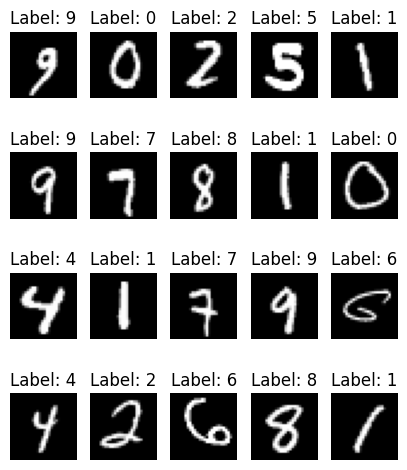

Each image is a torch.Tensor and has shape torch.Size([1, 28, 28]).
The labels are the integers 0 to 9, representing the digits.


In [3]:
fig, axs = plt.subplots(4, 5, figsize=(5, 6))

plot_images = []
plot_labels = []

for i, ax in enumerate(axs.flatten(), start=1000):
    (image, label) = test_data[i]

    # Save this data for later
    plot_images.append(image)
    plot_labels.append(label)

    # Plot each image
    ax.imshow(image.squeeze(), cmap="gray")
    ax.set_title(f"Label: {label}")
    ax.axis("off")
plt.show()

plot_images = torch.cat(plot_images)  # Combine all the images into a single batch for later

print(f"Each image is a torch.Tensor and has shape {image.shape}.")
print(f"The labels are the integers 0 to 9, representing the digits.")

In [4]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(784, 100)
        self.output = nn.Linear(100, 10)
    
    def forward(self, x):
        """
        Forward pass implementation for the network
        
        :param x: torch.Tensor of shape (batch, 1, 28, 28), input images

        :returns: torch.Tensor of shape (batch, 10), output logits
        """
        x = torch.flatten(x, 1)  # shape (batch, 28*28)
        x = self.hidden(x)
        x = F.relu(x)
        x = self.output(x)
        return x

# Setup a custom optimizer

Here, we will use a class with a similar interface to PyTorch's optimizers and implement SGD.

Try implementing your own version of another optimizer in the slides (but not Nesterov momentum).

Relevant documentation:
- [PyTorch optimizers](https://pytorch.org/docs/stable/optim.html)


In [5]:
class MySGD:
    def __init__(self, params, lr=1e-2):
        self.params = list(params)
        self.lr = lr
    
    def zero_grad(self):
        for p in self.params:
            p.grad = torch.zeros_like(p)

    def step(self):
        with torch.no_grad():
            for p in self.params:
                g = p.grad
                p -= self.lr * g    

In [6]:
class MyAdam:
    def __init__(self, parameters, lr=1e-3, beta_1=0.9, beta_2=0.999):
        self.lr = lr
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.parameters = [p for p in parameters]
        self.r = [torch.zeros_like(p) for p in self.parameters]
        self.s = [torch.zeros_like(p) for p in self.parameters]
        self._eps = 1e-8
        self.t = 0
    
    def zero_grad(self):
        for p in self.parameters:
            p.grad = torch.zeros_like(p)

    def step(self):
        self.t += 1
        with torch.no_grad():
            for i, p in enumerate(self.parameters):
                g = p.grad
                s = self.s[i]
                r = self.r[i]

                s = self.beta_1 * s + (1 - self.beta_1) * g
                r = self.beta_2 * r + (1 - self.beta_2) * g**2

                self.s[i] = s
                self.r[i] = r

                s_hat = s / (1 - self.beta_1 ** self.t)
                r_hat = r / (1 - self.beta_2 ** self.t)

                delta_p = -self.lr * s_hat / (torch.sqrt(r_hat) + self._eps)
                p += delta_p

In [7]:
# Test one step
model = MultiLayerPerceptron()
optimizer = MyAdam(model.parameters(), lr=1e-3)

loss_fn = nn.CrossEntropyLoss()
inputs = torch.randn((4, 1, 28, 28))
targets = torch.LongTensor([0, 1, 2, 3])

logits = model(inputs)
loss = loss_fn(logits, targets)
loss.backward()
optimizer.step()

In [8]:
def train(model, train_loader, loss_fn, optimizer, epoch=-1):
    """
    Trains a model for one epoch (one pass through the entire training data).

    :param model: PyTorch model
    :param train_loader: PyTorch Dataloader for training data
    :param loss_fn: PyTorch loss function
    :param optimizer: PyTorch optimizer, initialized with model parameters
    :kwarg epoch: Integer epoch to use when printing loss and accuracy
    :returns: Accuracy score
    """
    total_loss = 0
    all_predictions = []
    all_targets = []
    loss_history = []

    model.train()  # Set model in training mode
    for i, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()


        # Track some values to compute statistics
        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=-1)
        all_predictions.extend(preds.tolist())
        all_targets.extend(targets.tolist())

        # Save loss every 100 batches
        if (i % 100 == 0) and (i > 0):
            running_loss = total_loss / (i + 1)
            loss_history.append(running_loss)
            # print(f"Epoch {epoch + 1}, batch {i + 1}: loss = {running_loss:.2f}")

    acc = accuracy_score(all_targets, all_predictions)
    final_loss = total_loss / len(train_loader)
    # Print average loss and accuracy
    print(f"Epoch {epoch + 1} done. Average train loss = {final_loss:.2f}, average train accuracy = {acc * 100:.3f}%")
    return acc, final_loss

In [9]:
def test(model, test_loader, loss_fn, epoch=-1):
    """
    Tests a model for one epoch of test data.

    Note:
        In testing and evaluation, we do not perform gradient descent optimization, so steps 2, 5, and 6 are not needed.
        For performance, we also tell torch not to track gradients by using the `with torch.no_grad()` context.

    :param model: PyTorch model
    :param test_loader: PyTorch Dataloader for test data
    :param loss_fn: PyTorch loss function
    :kwarg epoch: Integer epoch to use when printing loss and accuracy

    :returns: Accuracy score
    """
    total_loss = 0
    all_predictions = []
    all_targets = []

    model.eval()  # Set model in evaluation mode
    for i, (inputs, targets) in enumerate(test_loader):
        with torch.no_grad():
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)

            # Track some values to compute statistics
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=-1)
            all_predictions.extend(preds.tolist())
            all_targets.extend(targets.tolist())

    acc = accuracy_score(all_targets, all_predictions)

    # Print average loss and accuracy
    print(f"Epoch {epoch + 1} done. Average test loss = {total_loss / len(test_loader):.2f}, average test accuracy = {acc * 100:.3f}%")
    return acc

# Test the implementation
Train a model for 5 epochs with both custom and PyTorch optimizer.

In [10]:
LEARNING_RATE = 1e-3
NUM_EPOCHS = 5
torch.manual_seed(0)
model = MultiLayerPerceptron()
# optimizer = MySGD(model.parameters, lr=LEARNING_RATE)
optimizer = MyAdam(model.parameters(), lr=LEARNING_RATE, beta_1=0.9, beta_2=0.999)
loss_fn = nn.CrossEntropyLoss()

In [11]:
train_metrics = []
test_metrics = []
train_losses_custom = []
for epoch in range(NUM_EPOCHS):
    train_acc, train_loss = train(model, train_loader, loss_fn, optimizer, epoch)
    train_losses_custom.append(train_loss)
    test_acc = test(model, test_loader, loss_fn, epoch)

    train_metrics.append(train_acc)
    test_metrics.append(test_acc)

Epoch 1 done. Average train loss = 0.27, average train accuracy = 92.068%
Epoch 1 done. Average test loss = 0.14, average test accuracy = 95.610%
Epoch 2 done. Average train loss = 0.12, average train accuracy = 96.510%
Epoch 2 done. Average test loss = 0.10, average test accuracy = 96.980%
Epoch 3 done. Average train loss = 0.08, average train accuracy = 97.448%
Epoch 3 done. Average test loss = 0.10, average test accuracy = 96.920%
Epoch 4 done. Average train loss = 0.06, average train accuracy = 98.003%
Epoch 4 done. Average test loss = 0.09, average test accuracy = 97.070%
Epoch 5 done. Average train loss = 0.05, average train accuracy = 98.367%
Epoch 5 done. Average test loss = 0.09, average test accuracy = 97.260%


In [12]:
torch.manual_seed(0)

model = MultiLayerPerceptron()
# optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999), eps=1e-8)
loss_fn = nn.CrossEntropyLoss()

train_metrics = []
test_metrics = []
train_losses_torch = []
for epoch in range(NUM_EPOCHS):
    train_acc, train_loss = train(model, train_loader, loss_fn, optimizer, epoch)
    train_losses_torch.append(train_loss)
    test_acc = test(model, test_loader, loss_fn, epoch)

    train_metrics.append(train_acc)
    test_metrics.append(test_acc)

Epoch 1 done. Average train loss = 0.27, average train accuracy = 92.083%
Epoch 1 done. Average test loss = 0.14, average test accuracy = 95.680%
Epoch 2 done. Average train loss = 0.12, average train accuracy = 96.513%
Epoch 2 done. Average test loss = 0.10, average test accuracy = 96.770%
Epoch 3 done. Average train loss = 0.08, average train accuracy = 97.477%
Epoch 3 done. Average test loss = 0.09, average test accuracy = 97.150%
Epoch 4 done. Average train loss = 0.06, average train accuracy = 97.915%
Epoch 4 done. Average test loss = 0.09, average test accuracy = 97.030%
Epoch 5 done. Average train loss = 0.05, average train accuracy = 98.355%
Epoch 5 done. Average test loss = 0.09, average test accuracy = 97.190%


# Visually compare the model predictions

We will lastly see the trained model's predictions on the 20 examples we visualized in the beginning.

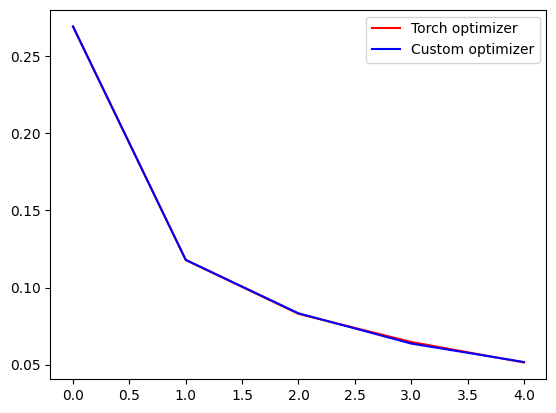

In [13]:
plt.plot(train_losses_torch, c="r", label="Torch optimizer")
plt.plot(train_losses_custom, c="b", label="Custom optimizer")
plt.legend()
plt.show()